**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline


In [2]:
# image space converter
def convert_image(image, space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image
        

# Define a function to return HOG features and visualization
# borrowed from udacity course tutorial
def get_hog_features(img, orient=9, pix_per_cell=2, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
# Borrowed form udacity course tutorial
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    ch1_features = cv2.resize(img[:,:,0], size).ravel() 
    ch2_features = cv2.resize(img[:,:,1], size).ravel() 
    ch3_features = cv2.resize(img[:,:,2], size).ravel() 
    features = np.hstack((ch1_features,ch2_features, ch3_features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# unless png data read by mpimg has been scaled back to 0-255
# Borrowed from udacity coruse tutorial
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Assumes image has RGB which is the default order when img is read
# using mpimg
# Borrowed from 
def extract_features(imgs, color_space='RGB', hog_space='RGB', img_type='JPG', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #if img_type == 'PNG': # PNG images read by mpimg are in range 0-1. 
        #    image = (image*255).astype(np.uint8)
            #image = image.astype(np.float32)/255 # Need to be scaled to 0-1
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_feature_image = convert_image(image, hog_space)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(hog_feature_image.shape[2]):
                    hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [3]:
# Extract features from dataset

def train_model(color_space='RGB', hog_space = 'RGB', img_type='PNG', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    t=time.time()

    #load files with sample images
    car_images = glob.glob('./dataset/vehicles/**/*.png', recursive=True)
    cars = []
    for image in car_images:
        cars.append(image)

    notcar_images = glob.glob('./dataset/non-vehicles/**/*.png', recursive=True)
    notcars = []
    for image in notcar_images:
        notcars.append(image)

    #extract features
    car_features = extract_features(cars, color_space=color_space, hog_space = hog_space, img_type= img_type, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, hog_space = hog_space, img_type= img_type, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()

    print(round(t2-t, 2), 'Seconds to extract features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial_size,
        'and', hist_bins,'histogram bins and hog with orientation of:', orient, 
        'pix_per_cell:', pix_per_cell, 'cell_per_block:', cell_per_block,
         'hog_channels:', hog_channel)

    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()

    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return X_scaler, svc

In [16]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, clf, scaler, color_space='RGB', hog_space = 'RGB',
                    window_scales = [1.0, 1.5], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) subset image to fixed lower size
    ystart=400
    ystop=656
    window=64 
    cells_per_step = 2
    img_tosearch = img[ystart:ystop, :, :]
    
        
    on_windows = []
    
    for scale in window_scales:
        #scale the image 
        # scale of 1 will mean window of size 64
        # scale of 1.5 will mean window of size 96 and so on
        feature_image = convert_image(img_tosearch, color_space)
        hog_image = convert_image(img_tosearch, hog_space)
        
        if scale != 1:
            imshape = img_tosearch.shape
            feature_image = cv2.resize(feature_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            hog_image = cv2.resize(hog_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        #4) Calculate no. of steps in each direction 
        nxblocks = (hog_image.shape[1] // pix_per_cell) - 1 #1280 // 8 -1 = 159
        nyblocks = (hog_image.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2
        
        nblocks_per_window = (window // pix_per_cell) -1 # 64/8-1 = 7
        
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step  # (159-7)/2 = 76
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        #5) get hog for the entire image
        if hog_feat:
            hog1 = get_hog_features(hog_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog2 = get_hog_features(hog_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog3 = get_hog_features(hog_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
        #6) extract features for each window
        for xb in range(nxsteps):
            for yb in range(nysteps):
                #6a) calculate window pixels 
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step #for xb=5 xpos = 5*2=10
                
                xleft = xpos*pix_per_cell # 10*8 = 80
                ytop= ypos*pix_per_cell

                #define empty array to hold features
                img_features = []
                subimg = cv2.resize(feature_image[ytop:ytop+window, xleft:xleft+window], (64, 64))
                if spatial_feat == True:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    img_features.append(spatial_features)
                #6d) Compute histogram features if flag is set
                if hist_feat == True:
                    hist_features = color_hist(subimg, nbins=hist_bins)
                    img_features.append(hist_features)
                #6e) get HOG features if flag is set
                if hog_feat == True:
                    # x indices are xpos:xpos+nblocks_per_windows = 10:17
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    if hog_channel == 'ALL':
                        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    elif hog_channel == 1:
                        hog_features = hot_feat1
                    elif hog_channel == 2:
                        hog_features = hot_feat2
                    else:
                        hog_features = hot_feat3

                    img_features.append(hog_features)
                
                features = np.concatenate(img_features)
                #print(features.shape)
                    
                test_features = scaler.transform(np.array(features).reshape(1, -1))
                #8) Predict using your classifier
                prediction = clf.predict(test_features)
                #9) If positive (prediction == 1) then save the window
                if prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    
                    on_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+ystart+win_draw)))
                
    #8) Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [5]:
def get_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    result = np.copy(heatmap)
    result[result <= threshold] = 0
    # Return thresholded map
    return result

def draw_labeled_bboxes(img, heatmap, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    result_img = np.copy(img)
    labels = label(heatmap)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(result_img, bbox[0], bbox[1], color, thick)
    # Return the image
    return result_img


class TrackHeatMaps:
        def __init__(self, n=5):
            self.n = n
            self.last_n_frames = [np.zeros((720,1280)) for i in range(self.n)]
            
        def add_row(self,row):
            self.last_n_frames = self.last_n_frames[1:]
            self.last_n_frames.append(np.copy(row))



In [6]:
def visualize_plots(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        #plt.title(i+1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

In [10]:
def pipeline(img, clf, scaler, color_space='RGB', hog_space='RGB', img_type='JPG',
                    track_frames = False, window_scales=[1], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, color=(0,0,255), thick=6, threshold=2, visualize=True):

    # trackmaps is a global variable
    global trackmaps
    
    # check if image needs scaling based on img_type
    result_img = np.copy(img)
    if img_type == 'JPG':
        result_img = (result_img.astype(np.float32))/255
        #result_img = result_img.astype(np.float32)/255 # Need to be scaled to 0-1 
    # search over all windows, extracting the image for window region and then run classifier to check
    # if window is hot
    hot_windows = search_windows(result_img, clf=clf, scaler=scaler, color_space=color_space, hog_space=hog_space,
                        window_scales=window_scales, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    heatmap = get_heat(img, hot_windows)
    if track_frames:
        trackmaps.add_row(heatmap)
        # get heatmap for hot windows across frames
        for h_map in trackmaps.last_n_frames:
            heatmap+= h_map
    
    #apply threholding to remove False Positives
    thresholded_heatmap = apply_threshold(heatmap, threshold=threshold)

    #draw labeled boxes to merge multiple detections into a single rectangle
    labeled_image = draw_labeled_bboxes(np.copy(img), thresholded_heatmap, color=color, thick=thick)

    if visualize:
        # all boxes_image

        # draw boxes before merging and thresholding
        hot_boxed_image = draw_boxes(np.copy(img), hot_windows, color=color, thick=thick)
        images = [img, hot_boxed_image, get_heat(img, hot_windows), heatmap, thresholded_heatmap, labeled_image] 
        titles = ['org', 'hot_boxed', 'frame_heatmap', 'cum_heatmap', 'thresh_heatmap', 'labeled']
        fig = plt.figure(figsize=(20,15))
        visualize_plots(fig, 3, 2, images, titles)
        
    return labeled_image

def process_img(img):
    #print(track_frames)
    labeled_image = pipeline(
                    img, clf=model, scaler=scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize)
    return labeled_image




In [11]:
# Parameters to tune for training classifier
spatial_size = (32,32)
hist_bins = 32
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_feat=True
hist_feat=True
hog_feat=True


In [12]:
scaler, model = train_model( color_space=color_space, hog_space = hog_space, img_type= 'PNG', 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)



93.18 Seconds to extract features...
Using spatial binning of: (32, 32) and 32 histogram bins and hog with orientation of: 9 pix_per_cell: 8 cell_per_block: 2 hog_channels: ALL
Feature vector length: 8460
10.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
0.0015 Seconds to predict 10 labels with SVC


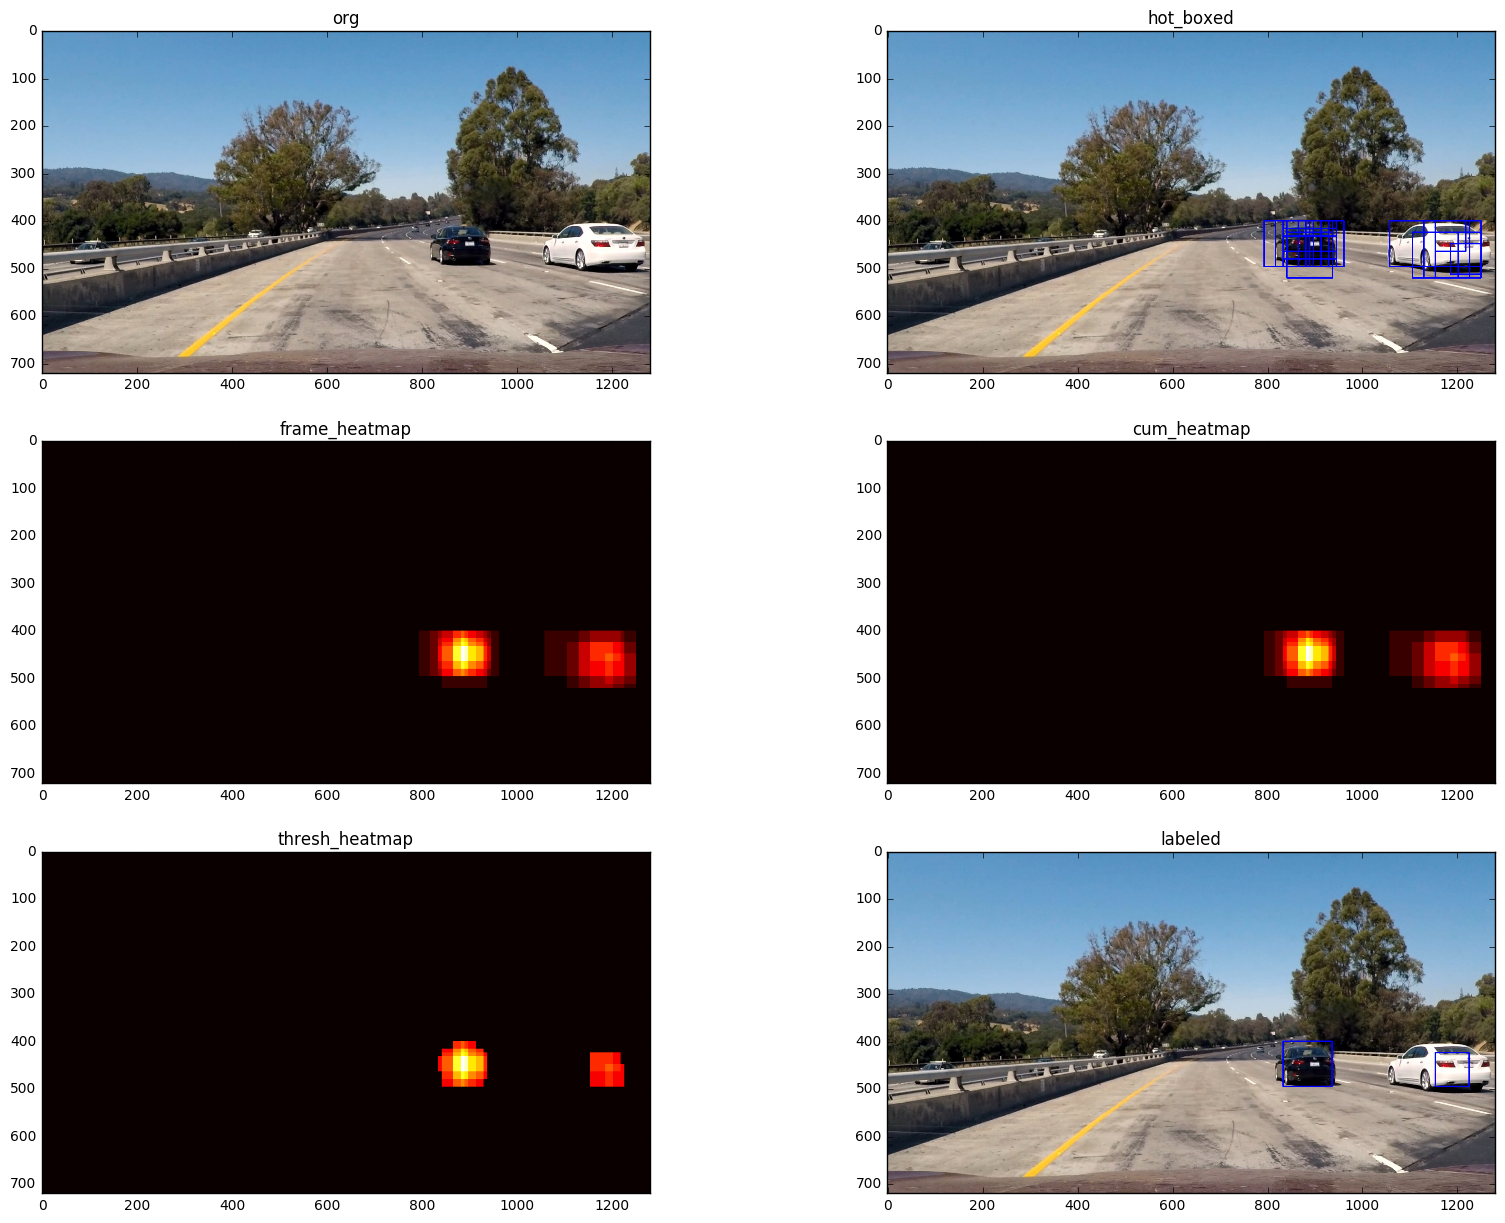

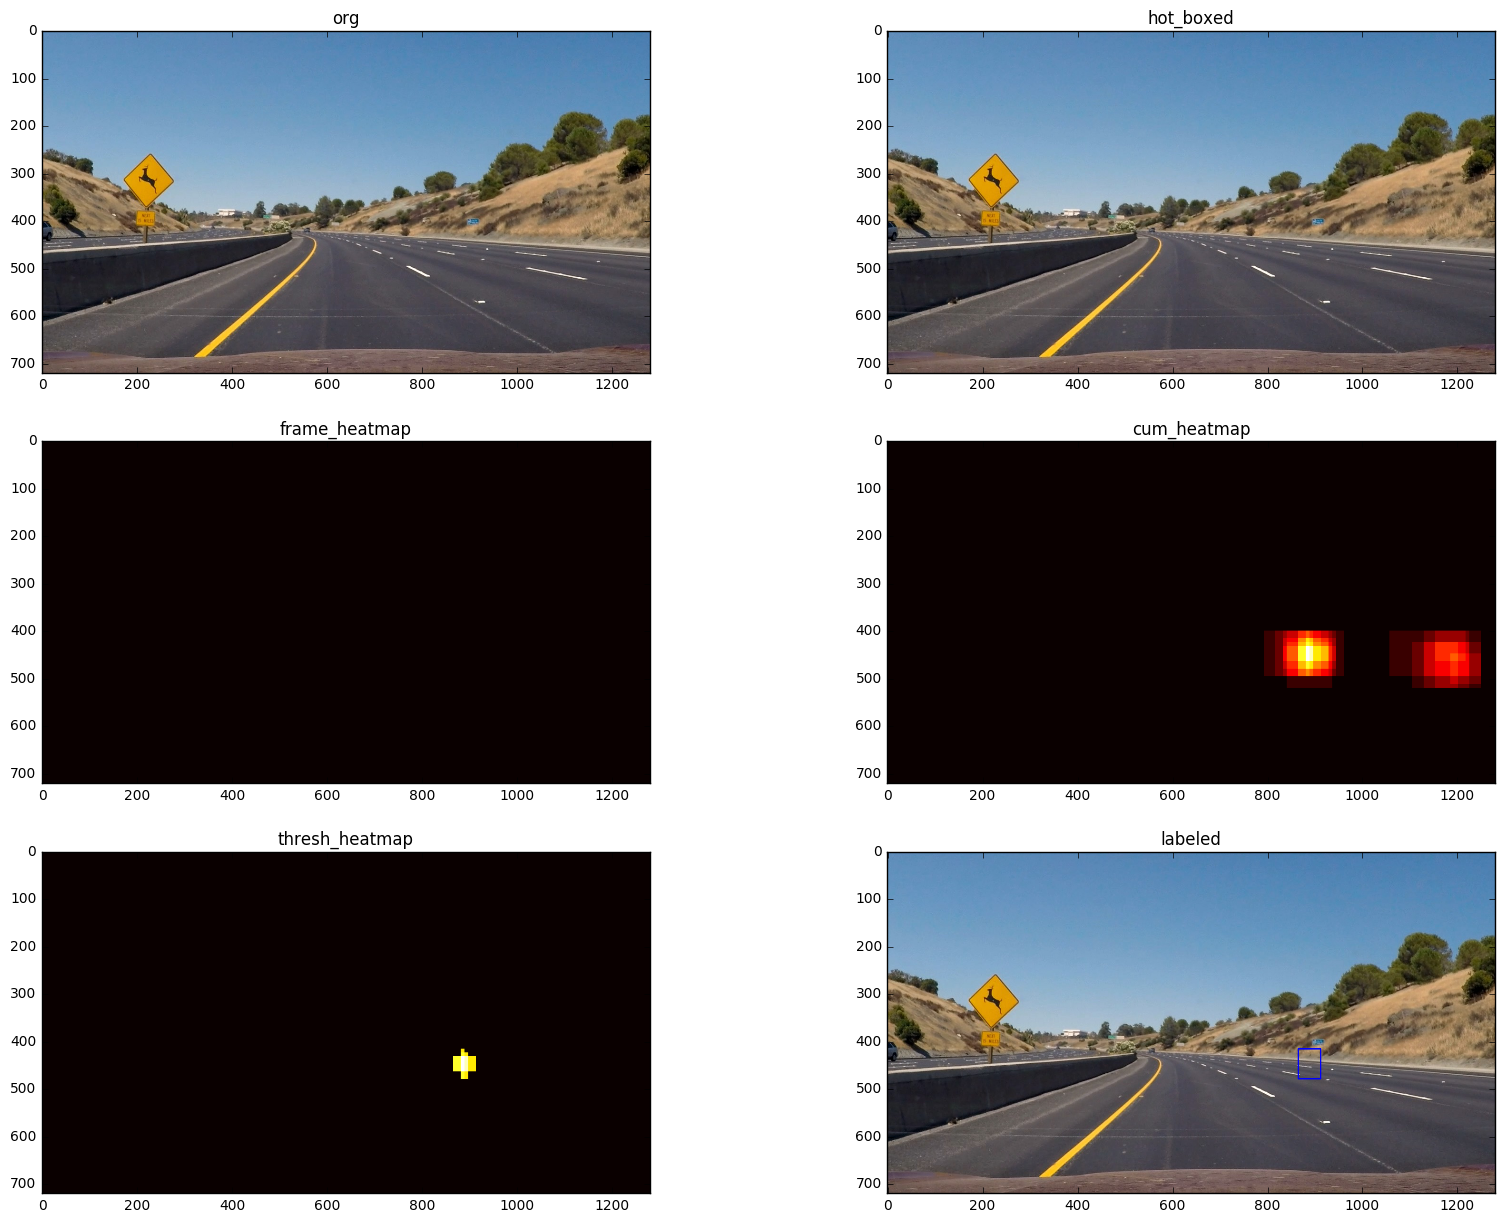

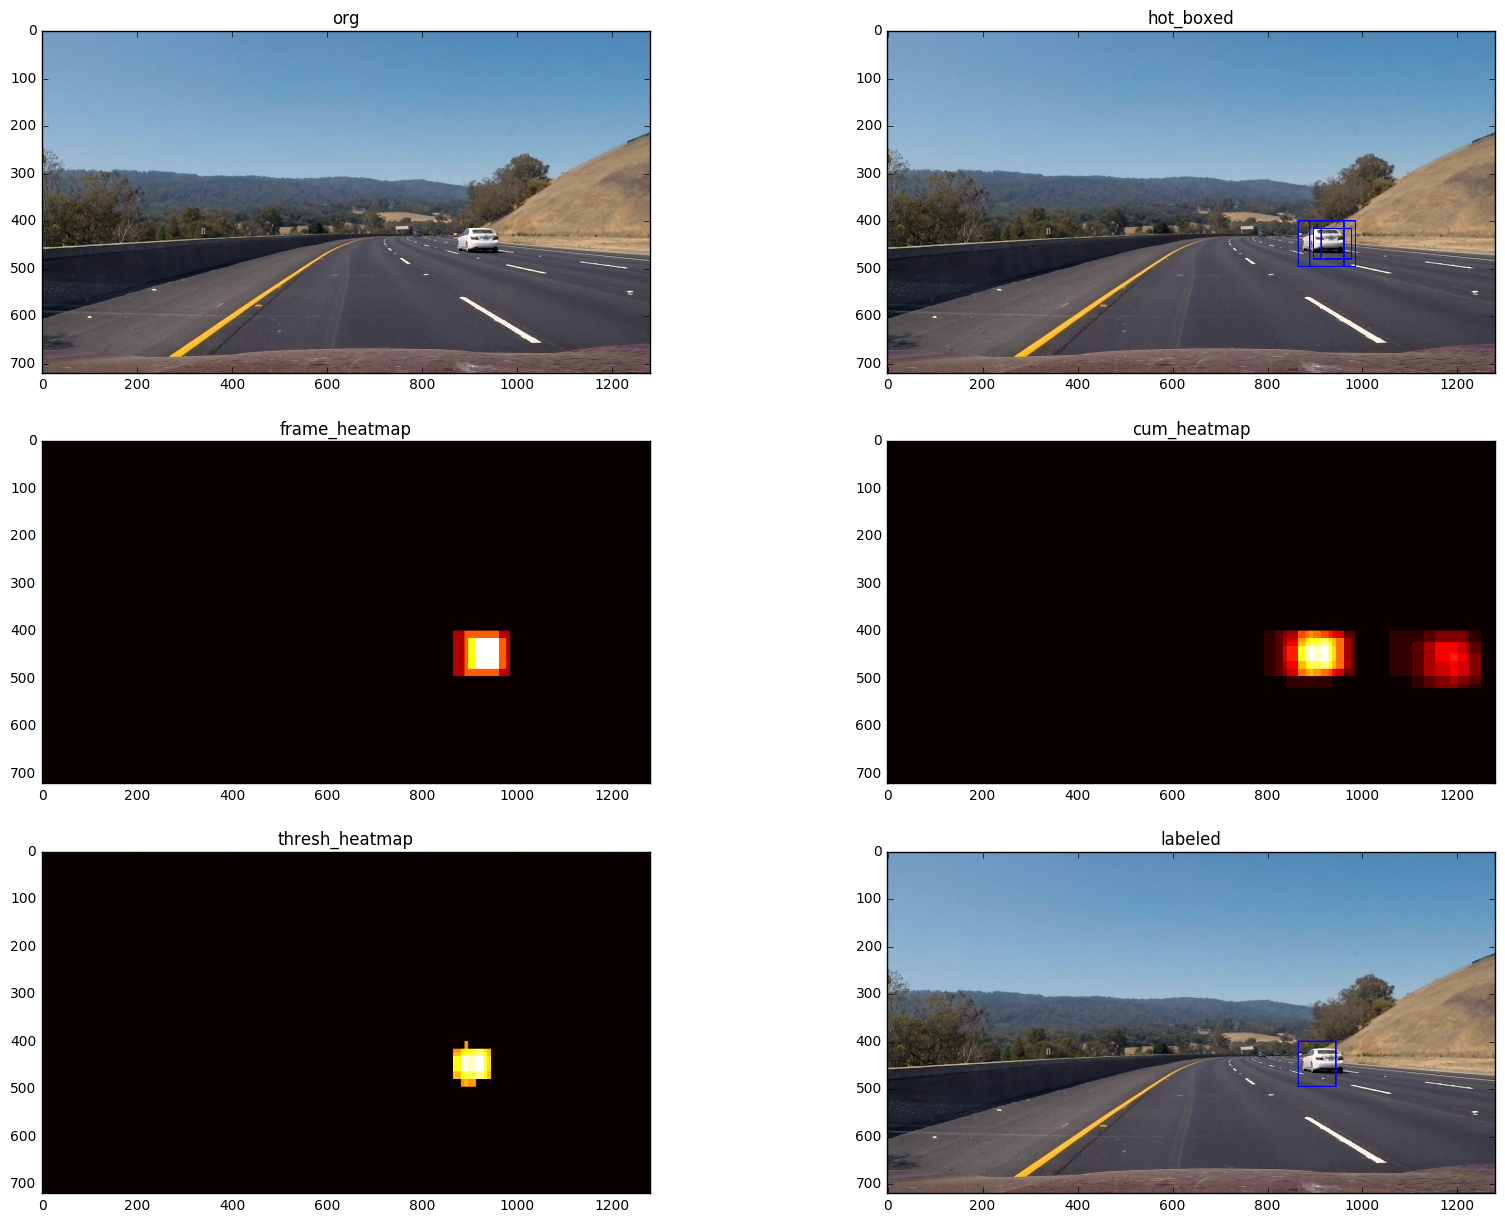

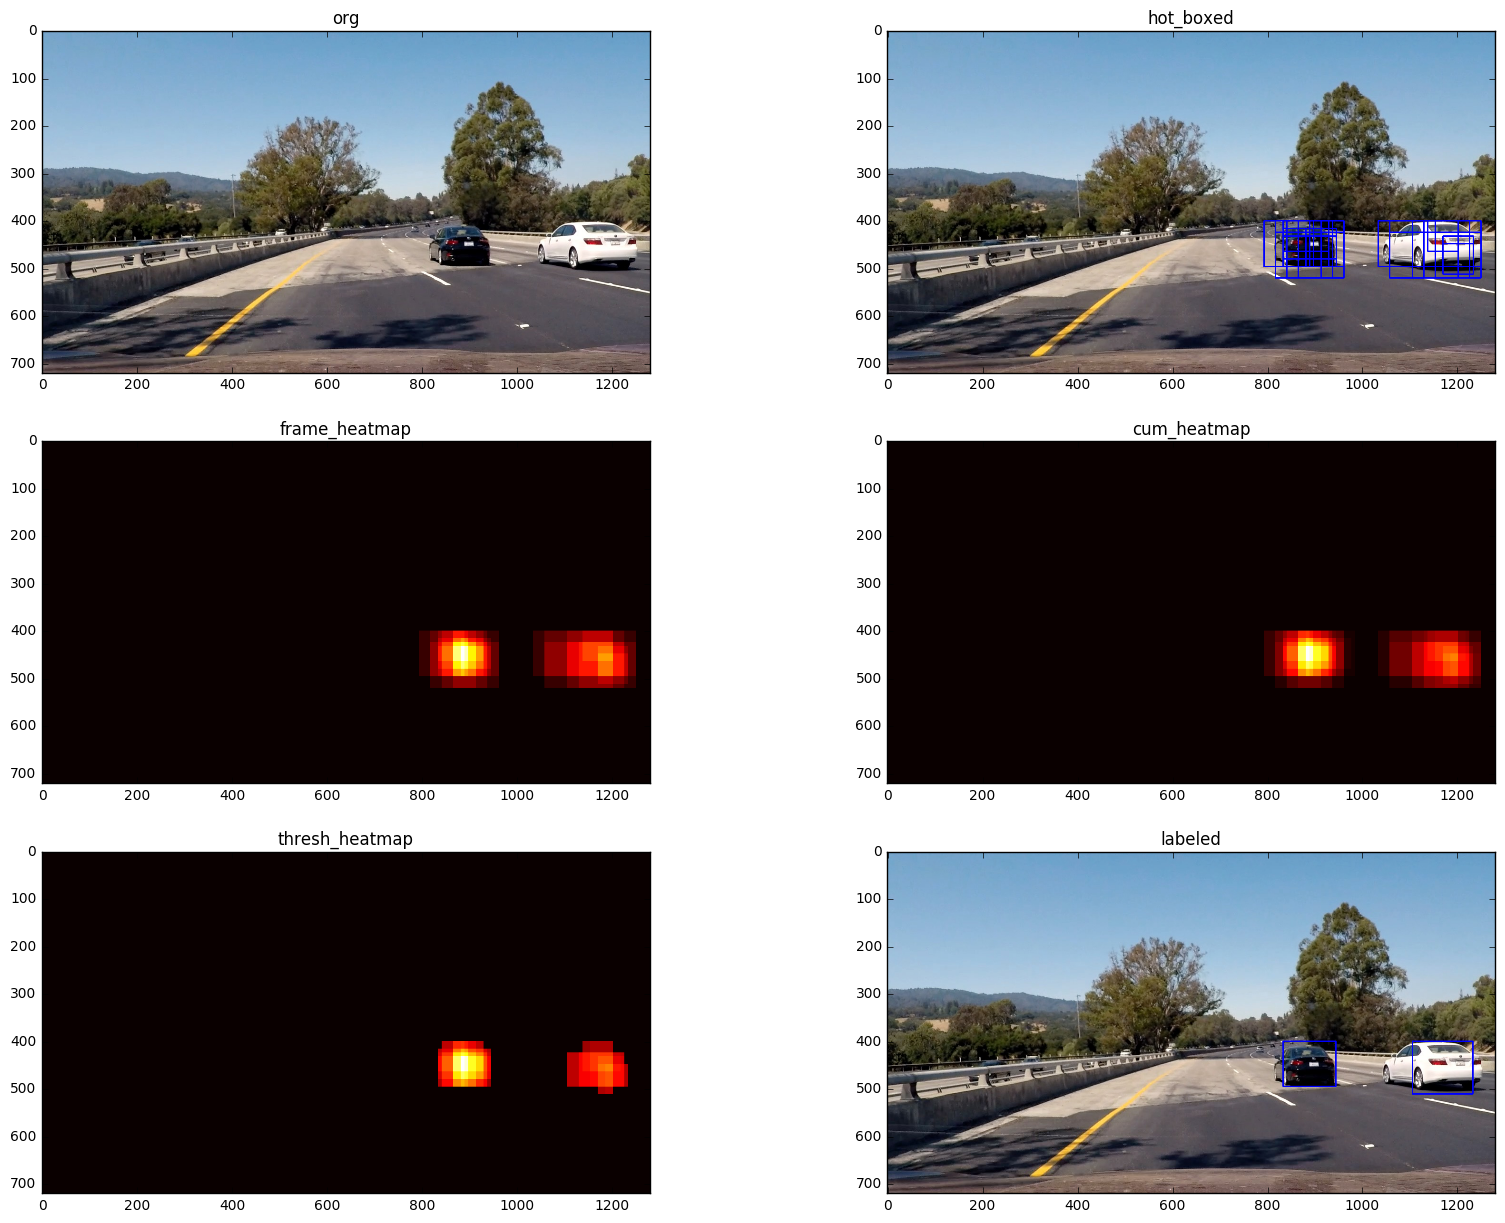

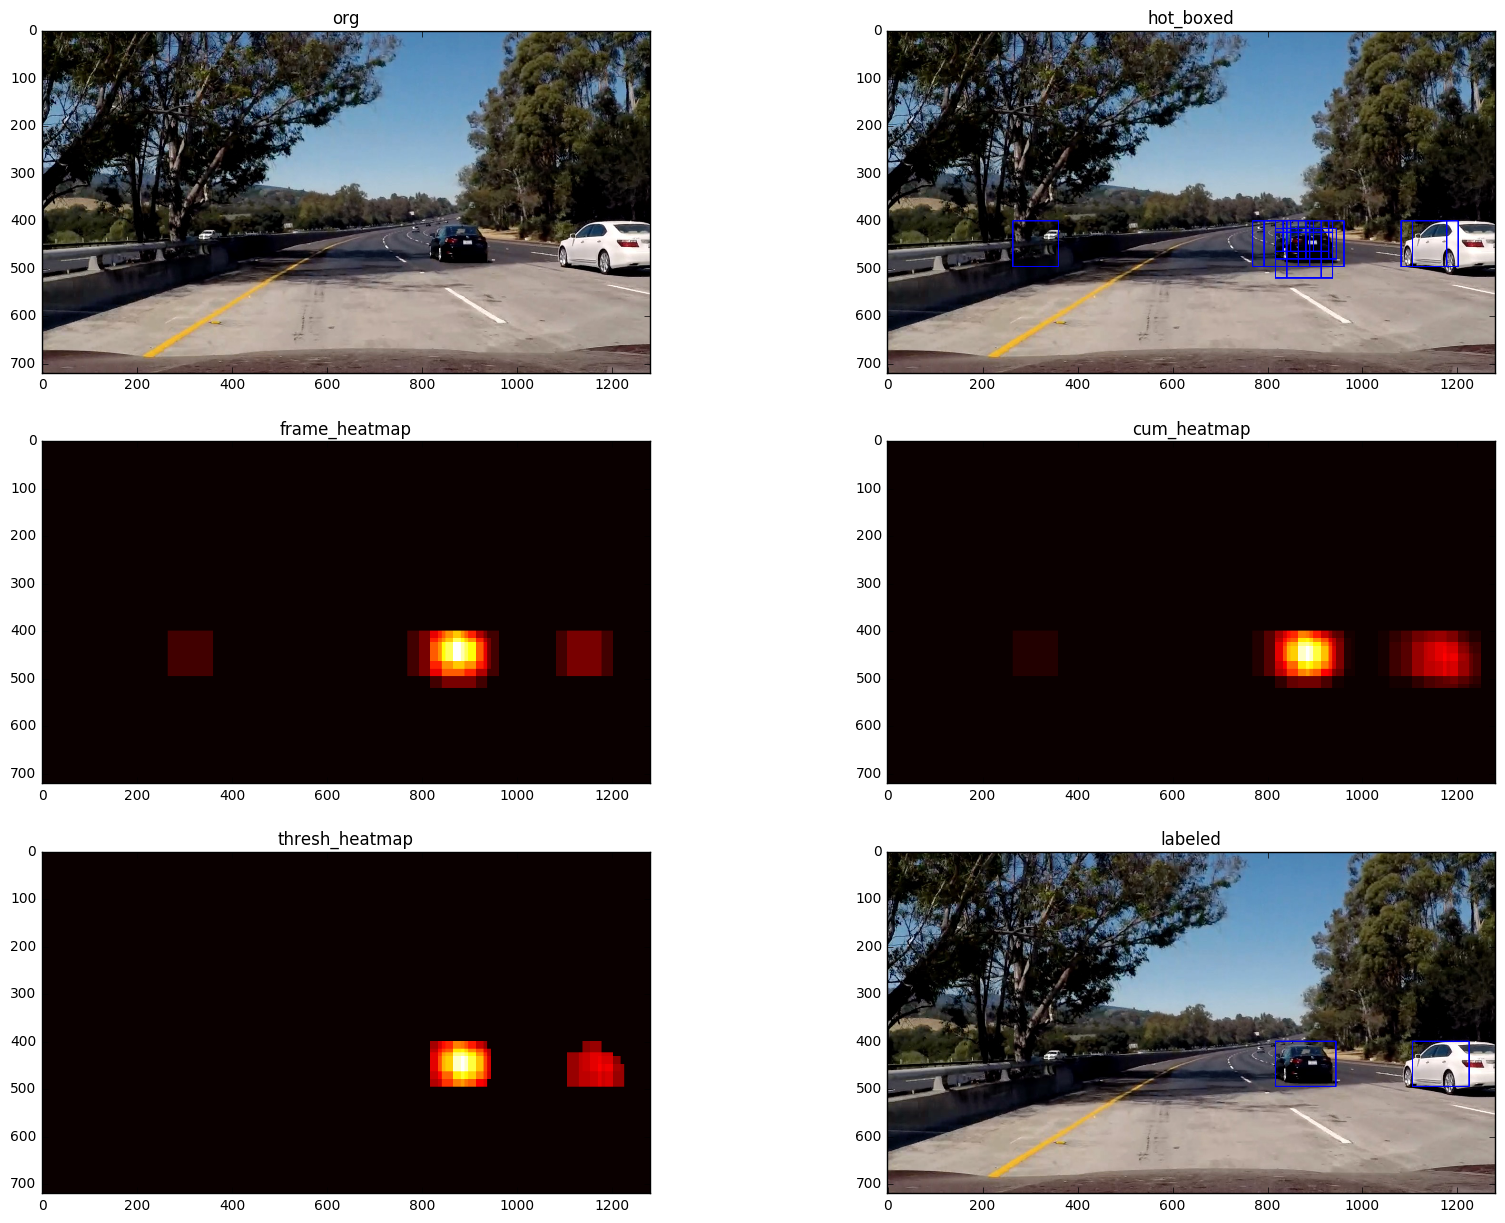

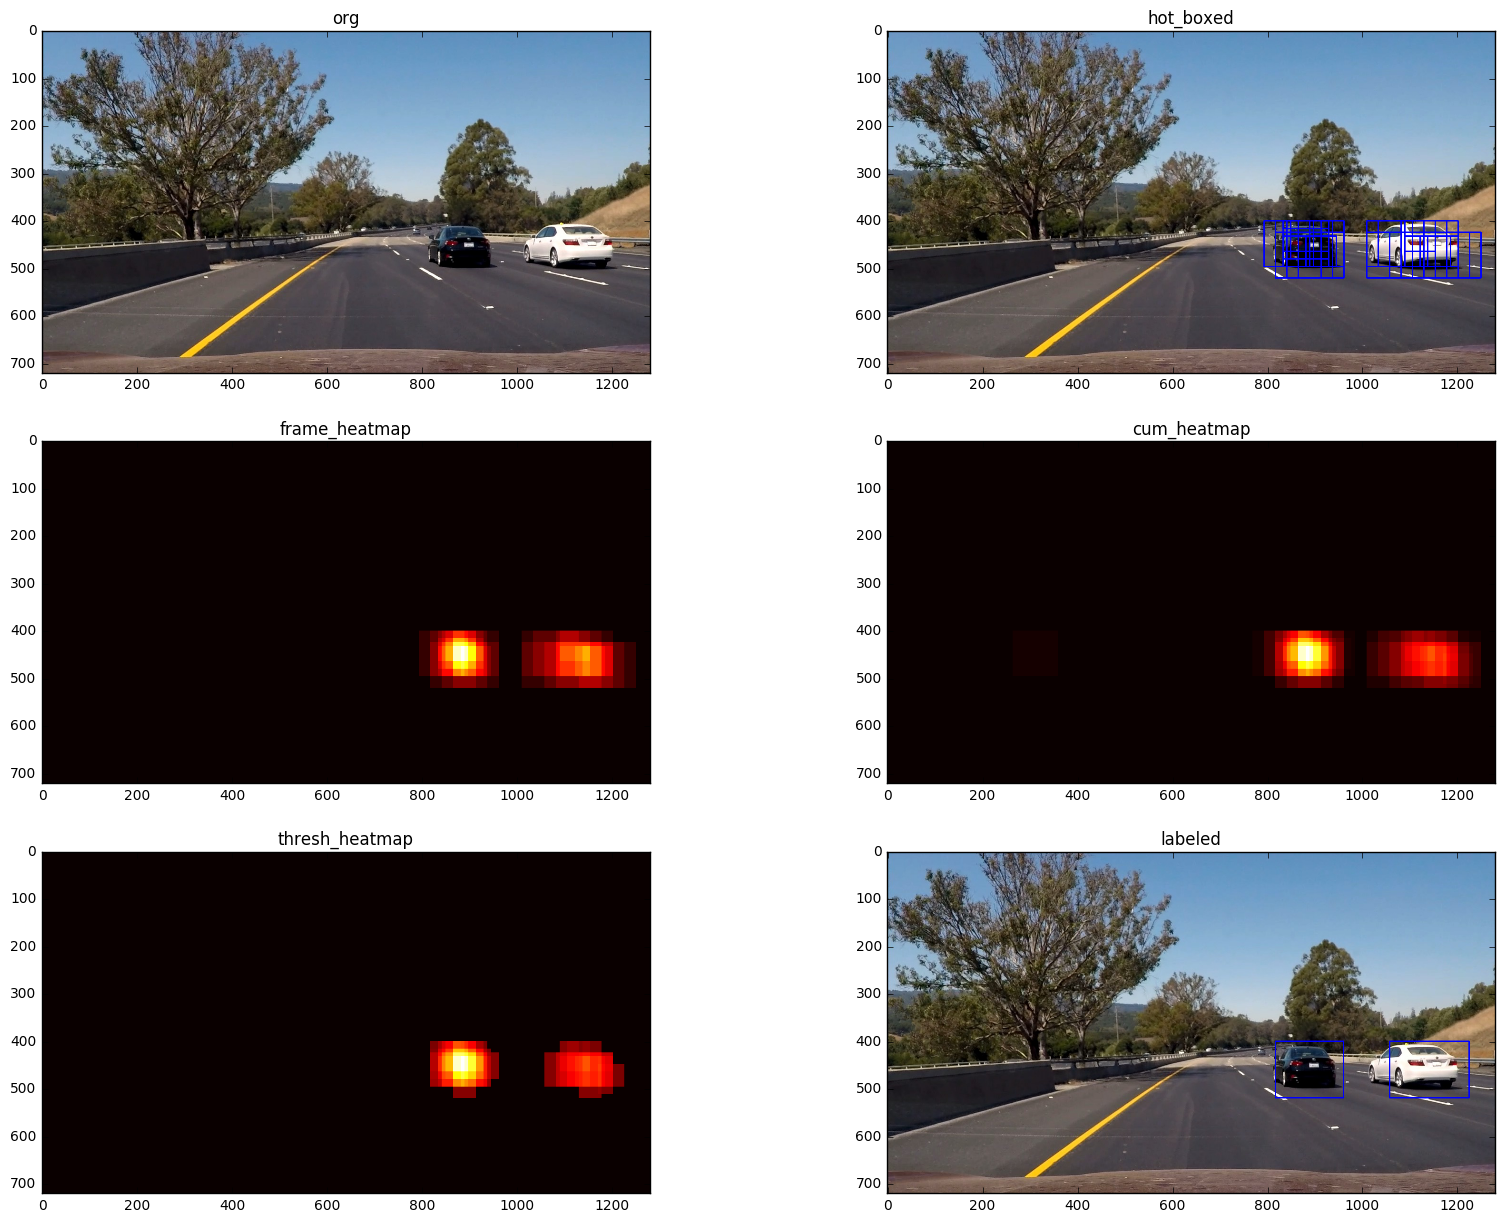

In [17]:
# run pipeline on 15 image pipeline
# parameters for search window and visualaization of pipeline
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=True
color=(0, 0, 255)
thick=2

images = []
for i in range(960,990):
    images.append('./new_samples/0'+str(i)+'.jpg')

images = glob.glob('./test_images/*.jpg')

    
trackmaps = TrackHeatMaps(n=5)

for f in images:
    img = mpimg.imread(f)
    process_img(img)


In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
# parameters for search window and visualaization of pipeline
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=False
color=(0, 0, 255)
thick=2

# Run pipeline
trackmaps = TrackHeatMaps(n=5)
video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_img)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [30:07<00:01,  1.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 30min 8s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))